In [1]:
# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Upload the kaggle.json API key manually or using the following code
from google.colab import files
files.upload()  # Upload your kaggle.json

# Step 3: Set up Kaggle API credentials
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

# Step 4: Download the dataset#!/bin/bash
! kaggle datasets download jp797498e/twitter-entity-sentiment-analysis

# Step 5: Unzip the dataset if necessary
!unzip /content/twitter-entity-sentiment-analysis -d /content/twitter-entity-sentiment-analysis

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 46.7MB/s]
Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: /content/twitter-entity-sentiment-analysis/twitter_training.csv  
  inflating: /content/twitter-entity-sentiment-analysis/twitter_validation.csv  


In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load training & validation datasets
train_df = pd.read_csv("/content/twitter-entity-sentiment-analysis/twitter_training.csv", header=None)
val_df = pd.read_csv("/content/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None)

# Assign column names
train_df.columns = ["id", "entity", "sentiment", "text"]
val_df.columns = ["id", "entity", "sentiment", "text"]

# Combine datasets
df = pd.concat([train_df, val_df], ignore_index=True)

# Display dataset info
print("\n Dataset Loaded! Shape:", df.shape)
print(df.head())

# Check for missing values
print("\n Checking Missing Values:\n", df.isnull().sum())

# Fill missing values
df.fillna("", inplace=True)



 Dataset Loaded! Shape: (75682, 4)
     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

 Checking Missing Values:
 id             0
entity         0
sentiment      0
text         686
dtype: int64


In [5]:
train_df.shape

(74682, 4)

In [6]:
train_df.isna().sum()

,0
id,0
entity,0
sentiment,0
text,686


In [7]:
train_df.duplicated().sum()

2700

In [8]:
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
train_df.shape

(71656, 4)

In [9]:
def bersihkan_teks(teks):
    # Mengubah semua teks menjadi huruf kecil
    teks = teks.lower()

    # Menghapus link/URL
    teks = re.sub(r'http\S+|www\S+|https\S+', ' ', teks, flags=re.MULTILINE)

    # Menghapus emoji dan karakter non-ASCII
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)

    # Menghapus tanda baca dan simbol lainnya
    teks = re.sub(r'[^a-zA-Z0-9\s]', ' ', teks)

    # Menghapus angka (opsional, jika tidak ingin menghapus angka, hapus baris ini)
    teks = re.sub(r'\d+', ' ', teks)

    # Menghapus spasi ganda yang mungkin terbentuk
    teks = re.sub(r'\s+', ' ', teks).strip()

    # Normalize Words
    teks = re.sub(r"won\'t", "would not", teks)
    teks = re.sub(r"im", "i am", teks)
    teks = re.sub(r"Im", "i am", teks)
    teks = re.sub(r"can\'t", "can not", teks)
    teks = re.sub(r"don\'t", "do not", teks)
    teks = re.sub(r"shouldn\'t", "should not", teks)
    teks = re.sub(r"needn\'t", "need not", teks)
    teks = re.sub(r"hasn\'t", "has not", teks)
    teks = re.sub(r"haven\'t", "have not", teks)
    teks = re.sub(r"weren\'t", "were not", teks)
    teks = re.sub(r"mightn\'t", "might not", teks)
    teks = re.sub(r"didn\'t", "did not", teks)
    teks = re.sub(r"n\'t", " not", teks)
    teks = re.sub(r"\'re", " are", teks)
    teks = re.sub(r"\'s", " is", teks)
    teks = re.sub(r"\'d", " would", teks)
    teks = re.sub(r"\'ll", " will", teks)
    teks = re.sub(r"\'t", " not", teks)
    teks = re.sub(r"\'ve", " have", teks)
    teks = re.sub(r"\'m", " am", teks)
    teks = re.sub(r'unk' , ' ' , teks)
    return teks
train_df['text'] = train_df['text'].apply(bersihkan_teks)
val_df['text'] = val_df['text'].apply(bersihkan_teks)

In [10]:
train_df.sample(5)

,id,entity,sentiment,text
44958,11721,Verizon,Negative,this is ridiculous pic twitter com tnehzobjs
8807,9510,Overwatch,Irrelevant,on overwatch league television set where the c...
72989,8902,Nvidia,Neutral,stayed up late night and order the psp graphic...
4858,35,Amazon,Positive,i certainly am so lucky to work hard for a com...
64912,7918,MaddenNFL,Negative,for maddenleagueops maddennfldirect sad


In [12]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# # Daftar stop words tambahan
# more_stop_words = ['im']
# stop_words.update(more_stop_words)
def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

# Terapkan preprocessing pada semua teks
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)

In [13]:
train_df.sample(5)

,id,entity,sentiment,text
32999,6462,Fortnite,Positive,noth scream left wing agenda like old ol fortnit
24330,4573,Google,Negative,tuckercarlson tonight fail mention elizabeth w...
69847,3967,Cyberpunk2077,Neutral,think happi result soon big pictur good challe...
29315,641,ApexLegends,Neutral,silver kill
4368,1952,CallOfDutyBlackopsColdWar,Positive,randomli went end game man miss game


In [14]:
kata_positif = train_df[train_df['sentiment'] == 'Positive']
sentimen_positif = kata_positif['text']
kata_negatif = train_df[train_df['sentiment'] == 'Negative']
sentimen_negatif = kata_negatif['text']
kata_netral = train_df[train_df['sentiment'] == 'Neutral']
sentimen_netral = kata_netral['text']
kata_irrelevant = train_df[train_df['sentiment'] == 'Irrelevant']
sentimen_irrelevant = kata_irrelevant['text']

<ipython-input-15-3b22f2713a0b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=train_df, x='sentiment', palette="Set2", edgecolor="black")


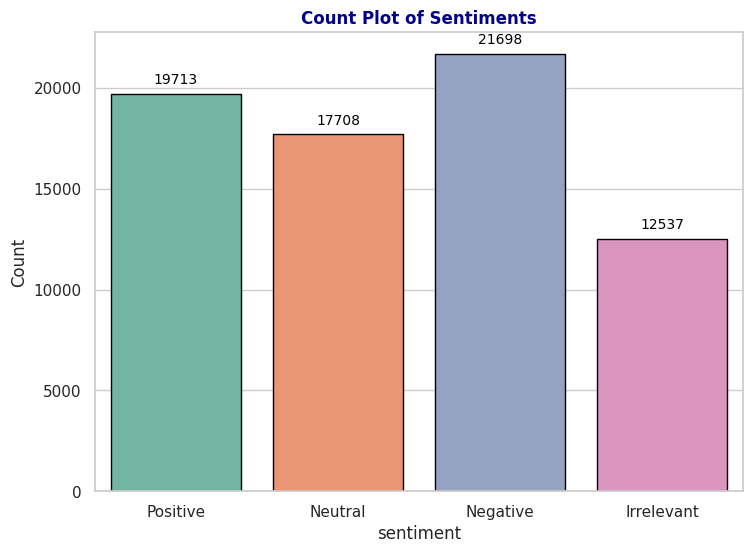

In [15]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=train_df, x='sentiment', palette="Set2", edgecolor="black")
plt.title(f'Count Plot of Sentiments', fontweight='bold', color='darkblue')
plt.ylabel("Count", fontsize=12)
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
plt.tight_layout(pad=2)
plt.show()

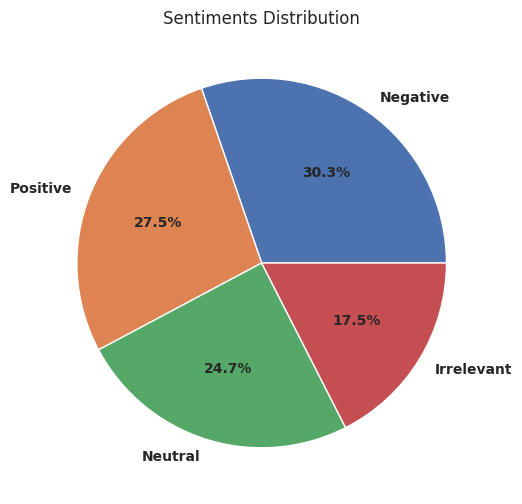

In [16]:
plt.figure(figsize=(6,6))
plt.pie(x =train_df['sentiment'].value_counts().values , labels=train_df['sentiment'].value_counts().keys() ,autopct="%1.1f%%" ,
textprops={"fontsize":10,"fontweight":"black"})
plt.title('Sentiments Distribution')
plt.show()

<ipython-input-17-b0bfa44b205e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


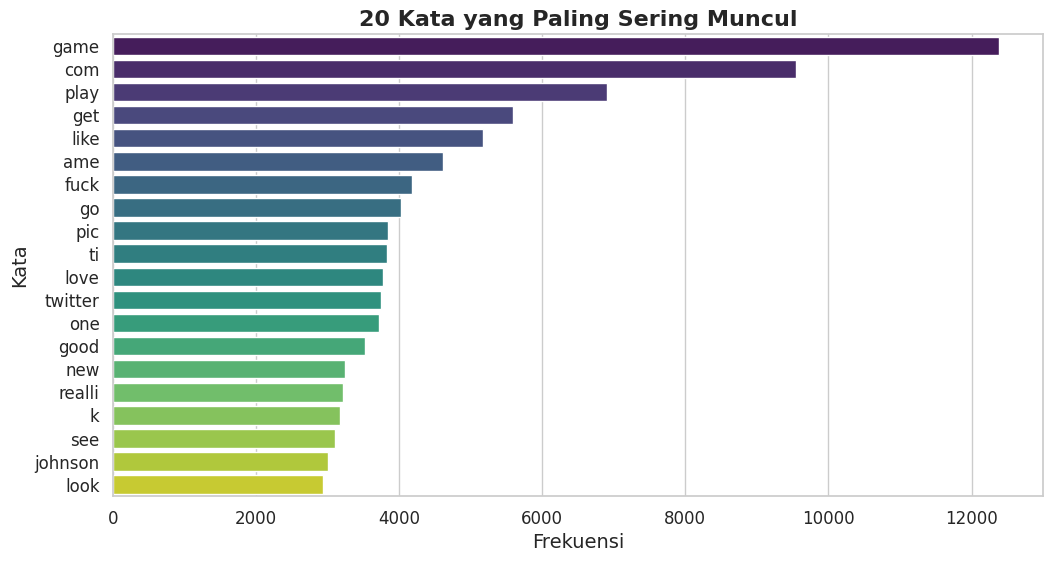

In [17]:
# Menggabungkan semua teks menjadi satu string
text = " ".join(train_df["text"])
tokens = text.split()

# Menghitung frekuensi kemunculan setiap kata
word_counts = Counter(tokens)

# Mengambil kata dengan frekuensi kemunculan tertinggi
top_words = word_counts.most_common(20)  # Ambil 20 kata teratas

# --- Visualisasi 1: Bar Chart ---
# Memisahkan kata dan jumlahnya
words, counts = zip(*top_words)

# Setup tema seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("20 Kata yang Paling Sering Muncul", fontsize=16, fontweight='bold')
plt.xlabel("Frekuensi", fontsize=14)
plt.ylabel("Kata", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

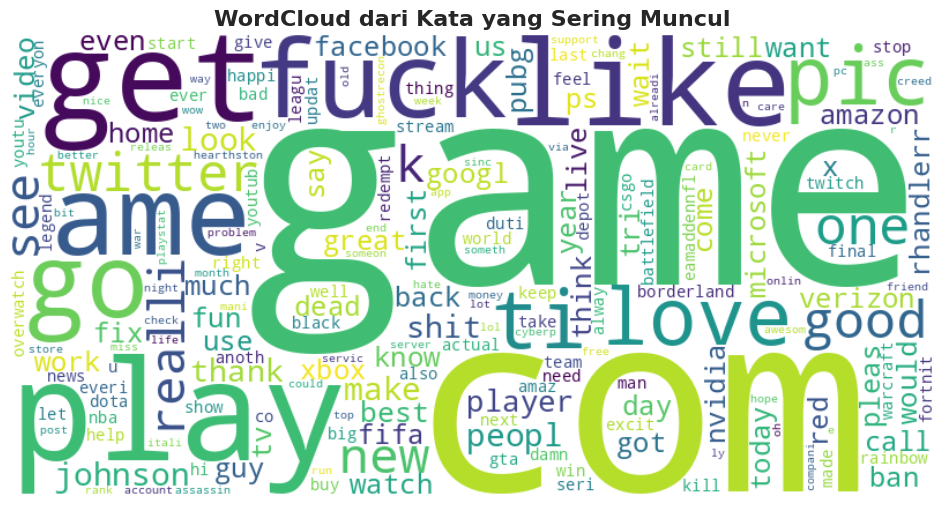

In [18]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(word_counts)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud dari Kata yang Sering Muncul", fontsize=16, fontweight='bold')
plt.show()

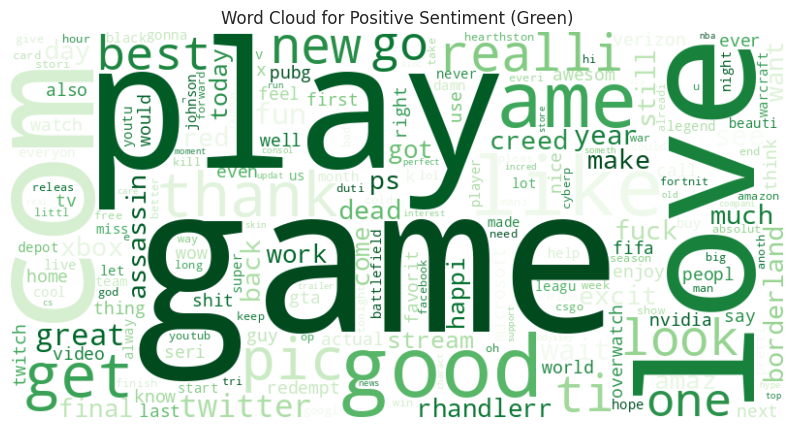

In [19]:
kata_positif = ' '.join(sentimen_positif)

# Tokenize the words and count frequency for positive sentiment
words_positif = kata_positif.split()
word_counts_positif = Counter(words_positif)

# Display the most common words for positive sentiment
common_words_positif = word_counts_positif.most_common(10)

# Create word cloud for positive sentiment with a green colormap
wordcloud_positif = WordCloud(
    width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(word_counts_positif)

# Plotting the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Sentiment (Green)")
plt.show()

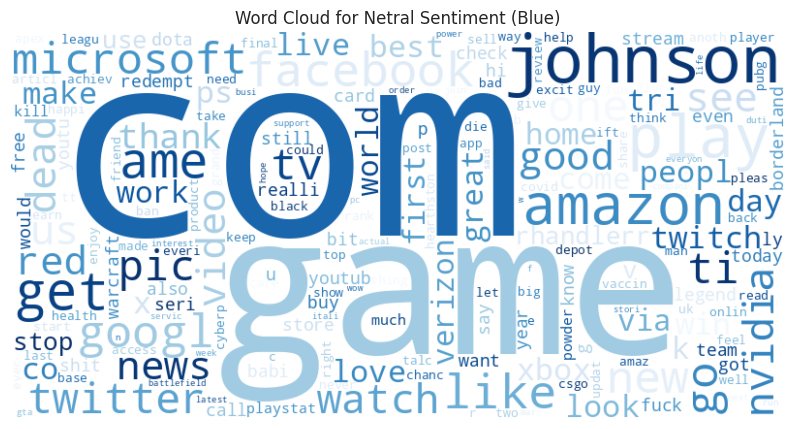

In [20]:
kata_netral = ' '.join(sentimen_netral)

# Tokenize the words and count frequency for netral sentiment
words_netral = kata_netral.split()
word_counts_netral = Counter(words_netral)

# Display the most common words for netral sentiment
common_words_netral = word_counts_netral.most_common(10)

# Create word cloud for netral sentiment with a red colormap
wordcloud_netral = WordCloud(
    width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(word_counts_netral)

# Plotting the word cloud for netral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Netral Sentiment (Blue)")
plt.show()

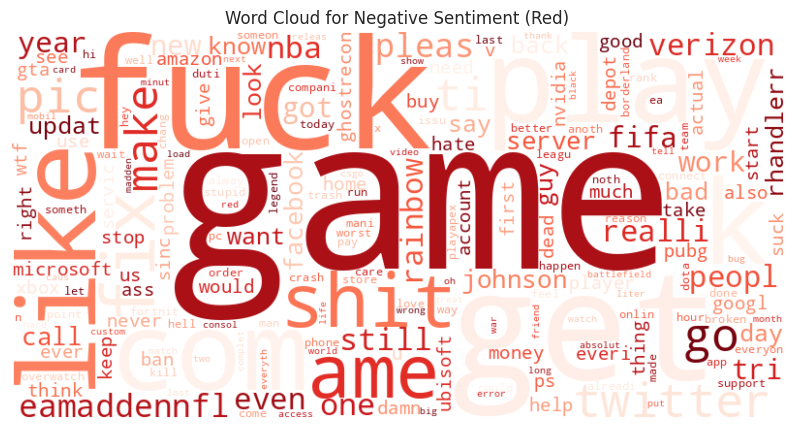

In [21]:
kata_negatif = ' '.join(sentimen_negatif)

# Tokenize the words and count frequency for negative sentiment
words_negatif = kata_negatif.split()
word_counts_negatif = Counter(words_negatif)

# Display the most common words for negative sentiment
common_words_negatif = word_counts_negatif.most_common(10)

# Create word cloud for negative sentiment with a red colormap
wordcloud_negatif = WordCloud(
    width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(word_counts_negatif)

# Plotting the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Sentiment (Red)")
plt.show()

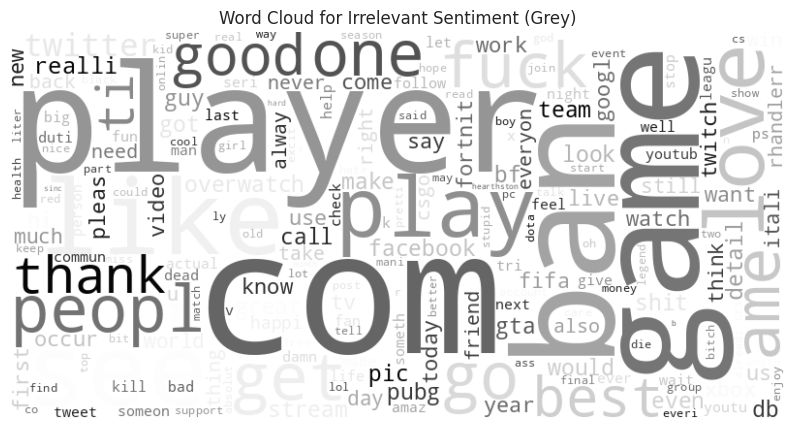

In [22]:
# Join all the positive and negative reviews into single strings
kata_irrelevant = ' '.join(sentimen_irrelevant)

# Tokenize the words and count frequency for negative sentiment
words_irrelevant = kata_irrelevant.split()
word_counts_irrelevant = Counter(words_irrelevant)

# Display the most common words for negative sentiment
common_words_irrelevant = word_counts_irrelevant.most_common(10)

# Create word cloud for negative sentiment with a red colormap
wordcloud_irrelevant = WordCloud(
    width=800, height=400, background_color='white', colormap='Greys').generate_from_frequencies(word_counts_irrelevant)

# Plotting the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_irrelevant, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Irrelevant Sentiment (Grey)")
plt.show()

In [23]:
train_df =train_df[['text','sentiment']]
train_df.sample(5)

,text,sentiment
56807,conflict feel rn,Negative
26710,castlevania witcher confid netflix video gamer...,Irrelevant
18877,earn horrif vision orgi ammar achiev,Neutral
43518,week disrupt tech curat rmnth pubg ban twist t...,Irrelevant
57731,rainbow game tri play sieg new xbox well sign,Negative


In [24]:
valid_df =val_df[['text','sentiment']]
valid_df.sample(5)

,text,sentiment
699,coronaviru vaccin race get desper johnson john...,Neutral
708,annnnnnnd one beauti k clutch rainbowsixsieg p...,Positive
224,week k uk hasnt drawn winner borderland collec...,Negative
692,bullshit excus appl real answer get cut micros...,Positive
947,btc scammer breach twitter account bill gate o...,Neutral


In [25]:
train_df['sentiment'] = train_df['sentiment'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })
valid_df['sentiment'] = valid_df['sentiment'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

<ipython-input-25-f83a89c7c45e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['sentiment'] = valid_df['sentiment'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })


In [26]:
train_texts = train_df['text'].values
train_labels = train_df['sentiment'].values

val_texts = valid_df['text'].values
val_labels = valid_df['sentiment'].values

In [27]:
tokenizer = Tokenizer(num_words=10000)  # Sesuaikan jumlah kata maksimum
tokenizer.fit_on_texts(train_texts)  # Tokenizer hanya di-fit pada data training

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

max_sequence_length = 100
X = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)

In [28]:
import pickle

# Simpan tokenizer ke file
with open('tokenizer2.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer telah disimpan.")

Tokenizer telah disimpan.


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.1, random_state=42)

In [30]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(val_labels)

In [31]:
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    layers.LSTM(64, return_sequences=True),
    # layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    # Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Menggunakan sparse loss
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# 6. Training Model
history = model.fit(
    X_train, train_labels,
    validation_data=(X_val, val_labels),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 100s 97ms/step - accuracy: 0.5964 - loss: 0.8434 - val_accuracy: 0.8550 - val_loss: 0.3994
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 145s 100ms/step - accuracy: 0.8274 - loss: 0.4319 - val_accuracy: 0.8980 - val_loss: 0.3039
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 141s 99ms/step - accuracy: 0.8753 - loss: 0.3045 - val_accuracy: 0.9210 - val_loss: 0.2662
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 142s 100ms/step - accuracy: 0.9034 - loss: 0.2409 - val_accuracy: 0.9170 - val_loss: 0.2989
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step - accuracy: 0.9194 - loss: 0.1977 - val_accuracy: 0.9280 - val_loss: 0.2991
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 141s 99ms/step - accuracy: 0.9290 - loss: 0.1719 - val_accuracy: 0.9290 - val_loss: 0.3305
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 144s 102ms/step - accuracy: 0.9396 - loss: 0.1464 - val_accuracy: 0.9290 - val_loss: 0.3313
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 140s 100ms/step - accur

In [33]:
test_loss, test_accuracy = model.evaluate(X_test,test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8836 - loss: 0.4415
Test Accuracy: 88.21%


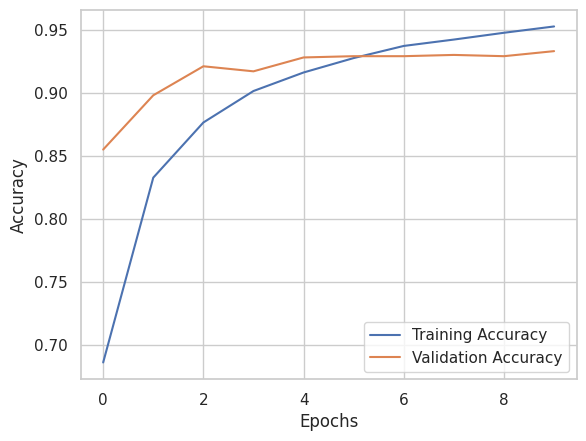

In [34]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


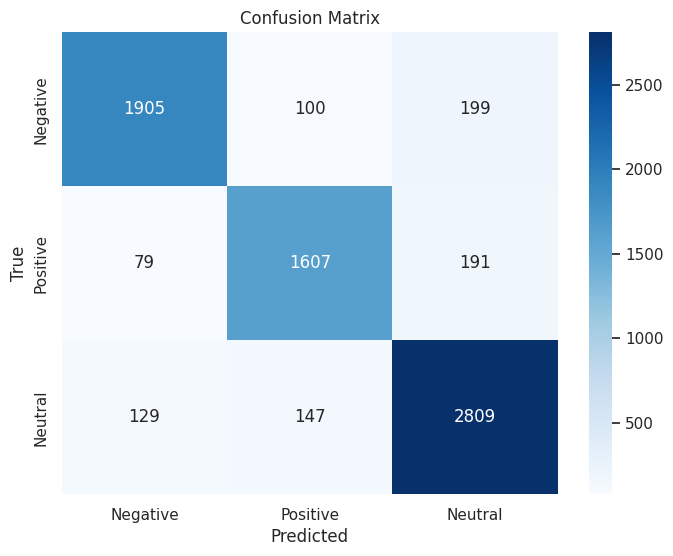

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = model.predict(X_test)
# If `y_pred_probs` is a 1D array, it directly contains the predicted class indices.
if len(y_pred_probs.shape) == 1:
    y_pred_labels = y_pred_probs
else:
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

# If `test_labels` is a 1D array, it directly contains the true class indices.
if len(test_labels.shape) == 1:
    y_true_labels = test_labels
else:
    y_true_labels = np.argmax(test_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
model.save('model.h5')

In [38]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load trained model
model = tf.keras.models.load_model("/content/model.h5")

# Load tokenizer
import pickle
with open("/content/tokenizer2.pkl", "rb") as file:
    tokenizer = pickle.load(file)

# Sentiment Mapping
sentiment_map = {0: "Negative", 1: "Positive", 2: "Neutral"}

# Function to preprocess text and make predictions
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])  # Convert text to sequence
    padded = pad_sequences(sequence, maxlen=150)  # Pad sequence
    prediction = model.predict(padded)  # Predict sentiment
    sentiment = sentiment_map[np.argmax(prediction)]  # Get predicted label
    return sentiment

# Sample Inputs
texts = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever received.",
    "The movie was okay, not too bad but not great either.",
    "I am so happy today!",
    "I don't know what to say, it's just neutral."
]

# Predict sentiment for each input
for text in texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: This is the worst service I have ever received.
Predicted Sentiment: Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: The movie was okay, not too bad but not great either.
Predicted Sentiment: Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Text: I am so happy today!
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: I don't know what to say, it's just neutral.
Predicted Sentiment: Negative

